In [ ]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

/home/anderson_walsh/UTK/COSC523Project2/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [1]:
train = '/home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training'
test = '/home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing'

In [2]:
import cv2
import numpy as np
import os

DATASET_PATH = '/home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/'

IMG_SIZE = 224

labels_map = {
    'glioma': 0,
    'meningioma': 1,
    'pituitary': 2,
    'notumor': 3  
}

def load_data(folder):
    X = []
    y = []
    for label in labels_map.keys():
        class_folder = os.path.join(folder, label)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(labels_map[label])
            except:
                print(f"Skipped corrupt image: {img_path}")
    return np.array(X), np.array(y)


In [3]:
X_train, y_train = load_data(os.path.join(DATASET_PATH, 'Training'))

X_test, y_test = load_data(os.path.join(DATASET_PATH, 'Testing'))

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (5712, 224, 224) (5712,)
Testing set: (1311, 224, 224) (1311,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

2025-05-03 18:33:16.761768: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 18:33:16.891714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746311596.942474  194593 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746311596.958001  194593 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 18:33:17.091511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
import tensorflow as tf
import numpy as np
def data_generator():
    for img, label in zip(X_train, y_train):
        img_array = np.array(img, dtype=np.uint8)
        yield img_array, label
def data_generator_val():
    for img, label in zip(X_val, y_val):
        img_array = np.array(img, dtype=np.uint8)
        yield img_array, label
train_ds = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(224, 224), dtype=tf.uint8),
        tf.TensorSpec(shape=(4,), dtype=tf.uint8)
    )
)
val_ds = tf.data.Dataset.from_generator(
    data_generator_val,
    output_signature=(
        tf.TensorSpec(shape=(224, 224), dtype=tf.uint8),
        tf.TensorSpec(shape=(4,), dtype=tf.uint8)
    )
)

I0000 00:00:1746311603.115400  194593 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomWidth, RandomHeight, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomRotation(0.2),
    RandomWidth(0.2),
    RandomHeight(0.2),
    RandomZoom(0.2),
])


In [7]:
def preprocess(img, label):
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.cast(label, tf.float32)
    return img, label
def preprocess_train(img, label):
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32) / 255.0
    #img = data_augmentation(img)
    #img = tf.image.resize(img, (224, 224))
    label = tf.cast(label, tf.float32)
    return img, label

In [8]:
train_ds = (
    train_ds
    .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

inputs = Input(shape=(224, 224, 3))


x = inputs

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model(x, training=False)

# Custom classification head
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [ ]:
from tensorflow.keras.metrics import AUC
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [ ]:
from tensorflow.keras import callbacks
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.01, monitor='val_accuracy', mode='max')
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


I0000 00:00:1745538618.349143  127245 service.cc:148] XLA service 0x7fc954010bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745538618.349181  127245 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-24 19:50:18.418644: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745538618.776945  127245 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-24 19:50:19.416190: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2323_0', 112 bytes spill stores, 144 bytes spill loads

2025-04-24 19:50:19.454791: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2323', 16 b

     22/Unknown 10s 6ms/step - accuracy: 0.3148 - loss: 0.5884

I0000 00:00:1745538625.873901  127245 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    139/Unknown 10s 7ms/step - accuracy: 0.5219 - loss: 0.4628

2025-04-24 19:50:27.448340: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2323', 16 bytes spill stores, 16 bytes spill loads

2025-04-24 19:50:27.586461: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7652', 12 bytes spill stores, 16 bytes spill loads

2025-04-24 19:50:27.624870: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7652', 24 bytes spill stores, 24 bytes spill loads

2025-04-24 19:50:27.679416: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7652', 32 bytes spill stores, 32 bytes spill loads

2025-04-24 19:50:27.711220: I external/local_xla/xla/stream_

    143/Unknown 14s 31ms/step - accuracy: 0.5259 - loss: 0.4601

2025-04-24 19:50:30.297639: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-24 19:50:30.297689: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2025-04-24 19:50:31.534210: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1191_0', 88 bytes spill stores, 120 bytes spill loads

2025-04-24 19:50:31.821714: I external/local_xla/xla/s

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.5269 - loss: 0.4594 - val_accuracy: 0.8390 - val_loss: 0.2058
Epoch 2/50
  2/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8047 - loss: 0.2607 

2025-04-24 19:50:35.919704: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8226 - loss: 0.2278 - val_accuracy: 0.8810 - val_loss: 0.1562
Epoch 3/50
 20/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8491 - loss: 0.1884

2025-04-24 19:50:37.228303: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8681 - loss: 0.1761 - val_accuracy: 0.8924 - val_loss: 0.1341
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8894 - loss: 0.1508 - val_accuracy: 0.9038 - val_loss: 0.1244
Epoch 5/50
 17/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9051 - loss: 0.1324

2025-04-24 19:50:39.729908: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9081 - loss: 0.1280 - val_accuracy: 0.9178 - val_loss: 0.1128
Epoch 6/50
131/143 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9078 - loss: 0.1200

2025-04-24 19:50:41.976588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141
2025-04-24 19:50:41.976632: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9083 - loss: 0.1196 - val_accuracy: 0.9213 - val_loss: 0.1043
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9268 - loss: 0.1048 - val_accuracy: 0.9230 - val_loss: 0.0987
Epoch 8/50
 18/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9363 - loss: 0.0870

2025-04-24 19:50:43.437324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113
2025-04-24 19:50:43.437420: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9364 - loss: 0.0892 - val_accuracy: 0.9300 - val_loss: 0.0924
Epoch 9/50
 18/143 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9297 - loss: 0.0895

2025-04-24 19:50:44.648411: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9363 - loss: 0.0840 - val_accuracy: 0.9353 - val_loss: 0.0888
Epoch 10/50
 18/143 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9434 - loss: 0.0719

2025-04-24 19:50:45.880080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113
2025-04-24 19:50:45.880125: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141


141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9533 - loss: 0.0696

2025-04-24 19:50:46.836264: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141
2025-04-24 19:50:46.836359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9533 - loss: 0.0696 - val_accuracy: 0.9423 - val_loss: 0.0839
Epoch 11/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9568 - loss: 0.0633 - val_accuracy: 0.9388 - val_loss: 0.0848
Epoch 12/50
 20/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9760 - loss: 0.0532

2025-04-24 19:50:48.369960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113
2025-04-24 19:50:48.370032: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9678 - loss: 0.0525

2025-04-24 19:50:49.324604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141
2025-04-24 19:50:49.324703: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9678 - loss: 0.0525 - val_accuracy: 0.9431 - val_loss: 0.0834
Epoch 13/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9670 - loss: 0.0532 - val_accuracy: 0.9396 - val_loss: 0.0830
Epoch 14/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.9651 - loss: 0.0456 - val_accuracy: 0.9484 - val_loss: 0.0796
Epoch 15/50
 19/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9799 - loss: 0.0338        

2025-04-24 19:56:41.774257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113
2025-04-24 19:56:41.774322: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141


143/143 ━━━━━━━━━━━━━━━━━━━━ -349s 8ms/step - accuracy: 0.9787 - loss: 0.0359 - val_accuracy: 0.9519 - val_loss: 0.0775


In [ ]:
classifier_head_weights = [layer.get_weights() for layer in model.layers[-8:]]

In [ ]:
from tensorflow.keras.models import load_model
#model = load_model("cnn_80_pretune.keras")

In [17]:
base_model.trainable = True

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [19]:
for i, layer in enumerate(model.layers[-8:]):
    layer.set_weights(classifier_head_weights[i])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_lr]
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9621 - loss: 0.0590 - val_accuracy: 0.9405 - val_loss: 0.0832 - learning_rate: 1.0000e-06
Epoch 2/50
 10/143 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9707 - loss: 0.0518

2025-04-24 19:51:02.319716: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-04-24 19:51:02.319762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141
2025-04-24 19:51:02.319778: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113


138/143 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9615 - loss: 0.0597

2025-04-24 19:51:03.348129: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141
2025-04-24 19:51:03.348167: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9615 - loss: 0.0597 - val_accuracy: 0.9405 - val_loss: 0.0833 - learning_rate: 1.0000e-06
Epoch 3/50
 17/143 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9716 - loss: 0.0576

2025-04-24 19:51:03.595359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9636 - loss: 0.0598 - val_accuracy: 0.9396 - val_loss: 0.0834 - learning_rate: 1.0000e-06
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9613 - loss: 0.0614
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9613 - loss: 0.0614 - val_accuracy: 0.9405 - val_loss: 0.0834 - learning_rate: 1.0000e-06
Epoch 5/50
134/143 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9700 - loss: 0.0530

2025-04-24 19:51:07.003352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141
2025-04-24 19:51:07.003404: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9699 - loss: 0.0531 - val_accuracy: 0.9405 - val_loss: 0.0835 - learning_rate: 5.0000e-07


2025-04-24 19:51:07.247160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9181168678023820141
2025-04-24 19:51:07.247192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15403732608327943113


In [ ]:
#model.save("cnn_95_mobilenet.keras")
from tensorflow.keras.models import load_model
#model = load_model("cnn_95_mobilenet.keras")

In [10]:
test_ds = tf.data.Dataset.from_generator(
    data_generator_val,
    output_signature=(
        tf.TensorSpec(shape=(224, 224), dtype=tf.uint8),
        tf.TensorSpec(shape=(4,), dtype=tf.uint8)
    )
)
test_ds = (
   	test_ds 
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1746311636.793660  412649 service.cc:148] XLA service 0x7fa8dc003130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746311636.793894  412649 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-03 18:33:56.817750: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746311637.015759  412649 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-03 18:33:57.601163: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1156', 16 bytes spill stores, 16 bytes spill loads

2025-05-03 18:33:57.665388: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1156_0', 112 by

     23/Unknown 59s 7ms/step

I0000 00:00:1746311694.845848  412649 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     33/Unknown 421s 11s/step

2025-05-03 18:34:56.053908: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1156', 16 bytes spill stores, 16 bytes spill loads

2025-05-03 18:34:56.142639: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1156_0', 344 bytes spill stores, 520 bytes spill loads

2025-05-03 18:34:56.271248: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1163_0', 352 bytes spill stores, 448 bytes spill loads

2025-05-03 18:34:56.341321: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1163', 4 bytes spill stores, 4 bytes spill loads

2025-05-03 18:34:56.514351: I external/local_xla/xla/s

36/36 ━━━━━━━━━━━━━━━━━━━━ 436s 11s/step


2025-05-03 18:41:11.678808: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_5401__.1185] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-05-03 18:41:11.748196: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m2.108835289s

********************************
[Compiling module a_inference_one_step_on_data_5401__.1185] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-05-03 18:41:11.755874: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generato

CNN Accuracy: 0.9405


2025-05-03 18:35:10.499304: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


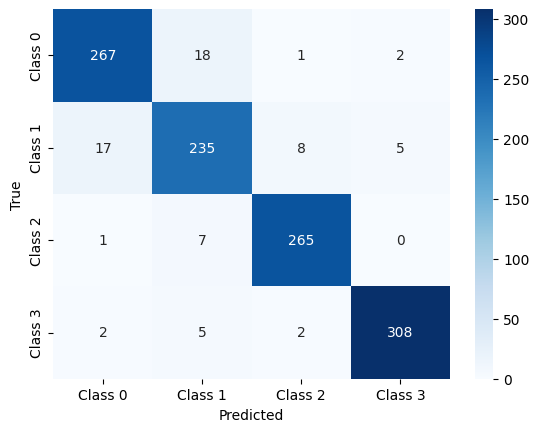

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_ds)

y_true = []
for _, label_batch in test_ds:
    y_true.append(label_batch.numpy())

y_true = np.concatenate(y_true, axis=0)

y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"CNN Accuracy: {acc:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
acc = accuracy_score(y_true, y_pred)
print(f"CNN Accuracy: {acc:.4f}")

precision = precision_score(y_true, y_pred, average=None)  # per class precision
recall = recall_score(y_true, y_pred, average=None)  # per class recall
f1 = f1_score(y_true, y_pred, average=None)  # per class f1 score

print("Precision (per class):", precision)
print("Recall (per class):", recall)
print("F1 Score (per class):", f1)

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("\nOverall (macro average) Precision:", precision_macro)
print("Overall (macro average) Recall:", recall_macro)
print("Overall (macro average) F1 Score:", f1_macro)

report = classification_report(y_true, y_pred, target_names=["glioma", "meningioma", "pituitary", "notumor"])
print("\nClassification Report:\n", report)

CNN Accuracy: 0.9405
Precision (per class): [0.93031359 0.88679245 0.96014493 0.97777778]
Recall (per class): [0.92708333 0.88679245 0.97069597 0.97160883]
F1 Score (per class): [0.92869565 0.88679245 0.96539162 0.97468354]

Overall (macro average) Precision: 0.9387571867485932
Overall (macro average) Recall: 0.939045147416766
Overall (macro average) F1 Score: 0.9388908176093063

Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.93      0.93       288
  meningioma       0.89      0.89      0.89       265
   pituitary       0.96      0.97      0.97       273
     notumor       0.98      0.97      0.97       317

    accuracy                           0.94      1143
   macro avg       0.94      0.94      0.94      1143
weighted avg       0.94      0.94      0.94      1143



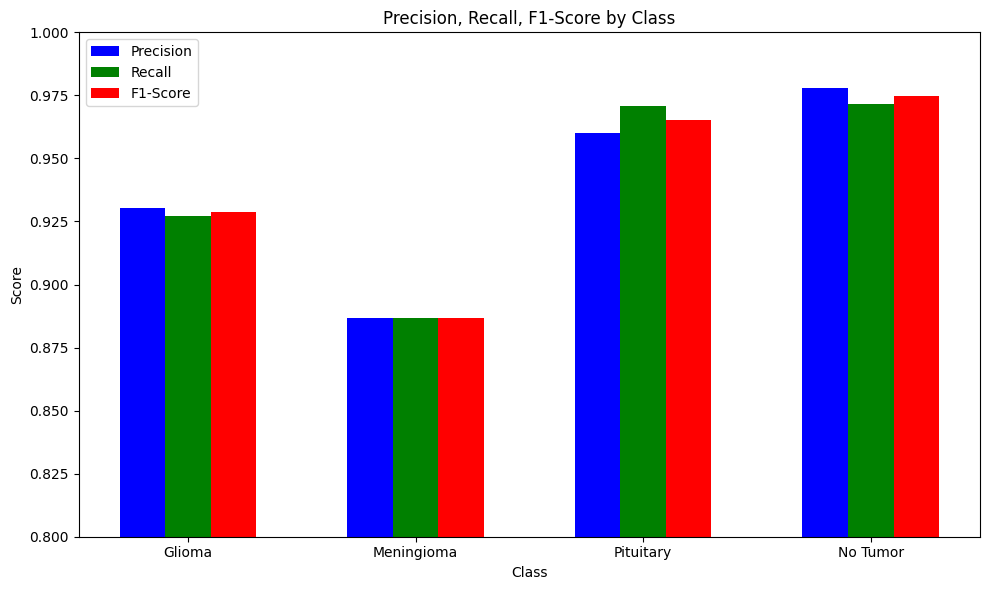

In [ ]:
precision = [0.93031359, 0.88679245, 0.96014493, 0.97777778]
recall = [0.92708333, 0.88679245, 0.97069597, 0.97160883]
f1_score = [0.92869565, 0.88679245, 0.96539162, 0.97468354]

classes = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

bar_width = 0.2
index = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, precision, bar_width, label='Precision', color='blue')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall', color='green')
bar3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score', color='red')


ax.set_ylim(0.8, 1)
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1-Score by Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()